In [ ]:
# requirements-
statsmodels
sklearn
numpy
pandas
tqdm
matplotlib
pylab

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.filters.hp_filter import hpfilter
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pylab as plt
plt.style.use('fivethirtyeight')
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

from pylab import rcParams
rcParams['figure.figsize'] = 10, 3

import warnings
warnings.filterwarnings('ignore')

# compare Test Statistic and Critical Values: should be in similar ranges
def adf_test(series, title='', verbose=0):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    if verbose>2:
        print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    
    if verbose>2:
        print(out.to_string())          # .to_string() removes the line "dtype: float64"
    

    if result[1] <= 0.05:
        if verbose>2:
            print("No trend present")
        trending=False
    else:
        if verbose>2:
            print("Trend is present")
        trending=True

    return trending


def get_trend(data:pd.DataFrame, keyword:str, 
              invert_y_axis:bool=True,
              date_column:str='Week', frequency:str='D', time_period:int=14,
              verbose:int=0)->float:
    """_summary_

    Args:
        data (pd.DataFrame): _description_
        keyword (str): keyword name
        invert_y_axis (bool, optional): _description_. Defaults to True.
        date_column (str, optional): Column for date data. Defaults to 'start_period'.
        frequency (str, optional): Data frequency. Defaults to 'D'.
        time_period (int, optional): duration for which to calculate trend score. Defaults to 14.
        verbose (int, optional): choose from 0, 1, 2, 3. Defaults to 0.

    Returns:
        float: _description_
    """

    sample = data.copy()
    sample[date_column] = pd.to_datetime(sample[date_column])
    # set date column as index
    sample.index = sample[date_column]
    if verbose>2:
        print(sample.info())

    # update frequency of data as required
    sample = sample[keyword].resample(frequency).mean().ffill()

    # limit as per given time period
    sample = sample.iloc[-time_period:]

    if verbose>2:
        if invert_y_axis:
            sample.plot(label='Original Data').invert_yaxis();
        else:
            sample.plot(label='Original Data')

    trending = adf_test(sample, verbose=verbose) # higher the p-value, higher is the trend

    if len(sample)>=180:
        # from 180 days and above
        lamb = 129600
    elif len(sample)>120:
        # from 121 days to 179 days
        lamb = 14400
    elif len(sample)>30:
        # from 31 days to 120 days
        lamb = 1600
    elif len(sample)>14:
        # from 15 to 30 days
        lamb = 100
    else:
        # upto 14 days
        lamb = 6.25

    if verbose>2:
        print('lamb:', lamb)

    # determine trend
    gdp_cycle, gdp_trend = hpfilter(sample, lamb=lamb)
    
    # create slope
    line = np.arange(start=gdp_trend.iloc[0], stop=gdp_trend.iloc[-1], step=(gdp_trend.iloc[-1]-gdp_trend.iloc[0])/len(gdp_trend))[-len(gdp_trend):]
    
    plot_data = pd.DataFrame()
    plot_data['trend'] = gdp_trend
    plot_data['ideal trend'] = line

    if invert_y_axis:
        angle = -np.rad2deg(np.arctan2(gdp_trend[-1]-gdp_trend[0], len(gdp_trend)))/90
    else:
        angle = np.rad2deg(np.arctan2(gdp_trend[-1]-gdp_trend[0], len(gdp_trend)))/90

    r2_score_ = max(-2, r2_score(plot_data['trend'], plot_data['ideal trend']))

    if verbose>1:
        print('Correlation R:', plot_data.corr()['ideal trend'].iloc[0])
        print('Variation accounted for:', r2_score_)
        print('angle:', angle)

    final_score = (3+plot_data.corr()['ideal trend'].iloc[0]+r2_score_)*angle/5
    if verbose>0:
        print('final_score', final_score)
        if invert_y_axis:
            plot_data.plot().invert_yaxis();
        else:
            plot_data.plot()
        
        plt.title(f"{keyword} trend line, score={round(final_score, 2)}");
        plt.legend();
        plt.show();
    
    return final_score


In [41]:
sample = pd.read_csv('multiTimeline_seasonal.csv', skiprows=2)
sample.head()

,Week,rain coat,vegan ice cream,leather jacket,macaroni recipe,tooth ache,gift hamper,easter egg,chocolate box,christmas tree,Symptoms of COVID-19,pfizer vaccine,covishield vaccine,g20 summit 2023,russia ukraine news live update
0,5/19/2019,11,59,43,35,58,12,3,22,2,0,0,0,0,0
1,5/26/2019,19,70,39,38,60,11,3,22,3,0,0,0,0,0
2,6/2/2019,35,70,34,35,61,10,3,22,2,0,0,0,0,0
3,6/9/2019,62,76,38,36,59,14,3,20,2,0,0,0,0,0
4,6/16/2019,32,69,37,32,62,9,4,22,2,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 262 entries, 2019-05-19 to 2024-05-19
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Week       262 non-null    datetime64[ns]
 1   rain coat  262 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.1 KB
None
Augmented Dickey-Fuller Test: 
ADF test statistic      -0.246544
p-value                  0.932741
# lags used              0.000000
# observations           3.000000
critical value (1%)    -10.417191
critical value (5%)     -5.778381
critical value (10%)    -3.391681
Trend is present
lamb: 6.25
Correlation R: 0.9976742905767241
Variation accounted for: 0.8618142273006499
angle: 0.8369984100499784
final_score 0.8134768326238977


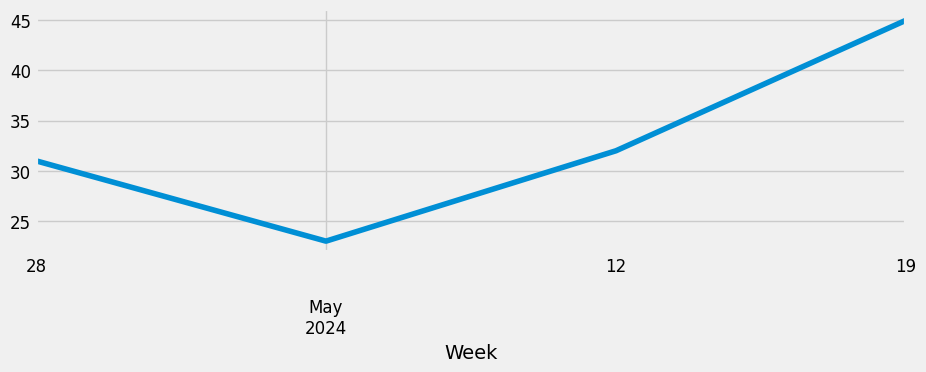

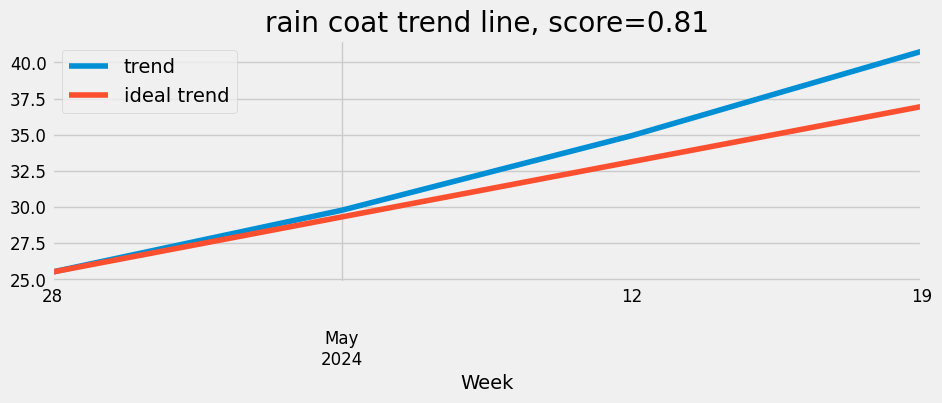

0.8134768326238977


In [47]:
keyword = 'rain coat'
time_period = 4 # 14, 30, 90, 365
frequency='W'
invert_y_axis=False
trend_score = get_trend(sample[['Week', keyword]], 
                        keyword, 
                      #   date_column='Day',
                        invert_y_axis=invert_y_axis, 
                        frequency=frequency, 
                        time_period=time_period,
                        verbose=4
                        )
print(trend_score)